# Lumo Run - Deep Fully Connected Neural Network

#### Load dependencies

In [129]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization 
from keras import regularizers 
from keras.optimizers import SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from datetime import datetime
from dateutil import tz
from IPython import embed
import time
from time import strftime, gmtime
import socket

from pathlib import Path
from sklearn.metrics import confusion_matrix 

np.random.seed(7) # Set seed for reproducibility

#### Set Hyperparameters

In [142]:
# Data Setup

num_channels = 7 # number of time-series channels of data (i.e. 7 kinematic features) #NOTE: Change to 6 by removing Pelvic Tilt (recommended by Lumo)
num_anthropometrics = 4 # number of user anthropometric data elements
input_window_size = 36 # number of timestamps used in the input for prediction (i.e. the input window)
label_window_size = 30 # number of timestamps used to label the speed we will be predicting
speed_bucket_size = '0.1' # how to round the data for classification task. Consider '0.5', '0.1', and 'none_use_regression'

model_architecture = 'CNN' # 'FCN', 'CNN'
data_input_table_structure = 'Raw_Timeseries' # 'Vectorized_By_Row' 'Raw_Timeseries'
myFileLocation = 'C:/Users/adam/Documents/CS 230/Project/Lumo Data/SAMPLE_TimeSeries_Longest1000Runs_wAnthro_MultiLabeledSpeed_20180523.csv'
        # Other data files to potentially use:
        # '../datasets/SAMPLE_TimeSeries_Longest1000Runs_wAnthro_MultiLabeledSpeed_20180523.csv'
        # '../datasets/quarter-big.csv'
        # '../datasets/TimeSeries_InputVector_15runs.csv'
        # 'C:/Users/adam/Documents/CS 230/Project/Lumo Data/TimeSeries_InputVector_100runs.csv'
        # 'C:/Users/adam/Documents/CS 230/Project/Lumo Data/SAMPLE_TimeSeries_Longest1000Runs_wAnthro_MultiLabeledSpeed_20180523.csv'
        
# Fully Connected Architecture

num_hidden_units_fc_layers = [256, 256, 256, 128, 128, 128]
num_hidden_fc_layers = len(num_hidden_units_fc_layers)

activations_fc_layers = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
activations_strategy = ''.join(str(num) + "_" for num in activations_fc_layers)

dropout_rate_fc_layers = [1.0, 1.0, 1.0, 0.8, 0.8, 0.8]
dropout_rates = ''.join(str(num) + "_" for num in dropout_rate_fc_layers)

# Convolutional Architecture

kernel_size = 6
depth = 40
num_hidden = 50 # number of hidden neurons on hidden layer of CNN
sample_stride=18
input_height = 1
max_pool_kernel_size=6
loss_function = "cross_entropy" #options are: "L1_loss" , "cross_entropy" , "L2_loss"
optimizer_type = "gradient" #options are: "adam" , "rmsprop", "gradient"
activation_conv_layer = "relu" #options are "relu" , "tanh" and "sigmoid" - used for depthwise_conv
activation_fc_layer = "tanh" #options are "relu" , "tanh" and "sigmoid" - used for final FC layer


# Training strategy

batch_size = 128
learning_rate = 0.0001
training_epochs = 2
loss_function = 'categorical_crossentropy' # Other options (from keras defaults or custom) include: 'categorical_crossentropy' ,'mse', 'mae', 'class_mse', 'class_mae'

#### Set Up Automatic Reporting and Plotting

In [143]:
# Choose the 3 most interesting evaluation metrics to report on in final plots

accuracy_reporting_metric_1 = 'class_mae' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_1 = 'val_' + accuracy_reporting_metric_1
accuracy_reporting_metric_2 = 'class_percent_2buckRange' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_2 = 'val_' + accuracy_reporting_metric_2
accuracy_reporting_metric_3 = 'class_mse' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_3 = 'val_' + accuracy_reporting_metric_3

plt.style.use('ggplot') # style of matlab plots to produce

In [144]:
# File naming conventions

file_name = strftime("%Y%m%d_%H%M%S", gmtime()) # user input for filename of saved model
results_file_name = "Default_Model_Results_Storage_Table_20180712"
plot_note = ""
model_to_lod = ""

customize_file_names = False
if customize_file_names:
    file_name = input("String to add to model filename (defaults to time stamp if nothing entered):")  
    results_file_name = input("Name of the results file, a table, to store the prediction results") # name of results file
    plot_note = input("Note you'd like to add in the legend of the primary learning curves plot:") #user input to add note to plot
    model_to_load = input("Enter the model name to load to initialize parameters - leave blank to start fresh") #user input to load prev model

#### Define functions for data processing and plotting

In [145]:
def read_data(file_path):
    data = pd.read_csv(file_path,header = 0) # This uses the header row (row 0) as the column names
    return data

def windows(data, size): # define time windows to create each training example
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += 1 # other common options: (size / 2)

def segment_signal_FCN_vector(data_inputs, data_full): # Used for vectorized input WITH SQL pre-processing
    dataframe_input = data_inputs.loc[:, 'gender':'pelvic_tilt_lag_0'] # select all columns from gender to pelvic_tilt_lag_0
    dataframe_labels = data_full.loc[:, 'gps_speed_lag_7':'gps_speed_lag_3'] # select all columns from gender to pelvic_tilt_lag_0
    segments = dataframe_input.values
    labels_before_avg = dataframe_labels.values
    if speed_bucket_size == '0.1':
        labels = np.around(np.mean(labels_before_avg, axis=1),decimals=1)
    elif speed_bucket_size == '0.5':
        labels = np.around(2*np.mean(labels_before_avg, axis=1),decimals=0)/2
    elif speed_bucket_size == 'none_use_regression':
        labels = np.mean(labels_before_avg, axis=1)
    return segments, labels

def segment_signal(data_inputs, data_full, input_window_size = input_window_size): # Used for vectorized input WITHOUT SQL pre-processing
    if  model_architecture == 'FCN':
        segments = np.empty((0,input_window_size*num_channels + num_anthropometrics))
    elif model_architecture == 'CNN':
        segments = np.empty((0, input_window_size, num_channels + num_anthropometrics))
    labels = np.empty((0))
    for (start, end) in windows(data_full['timestamp'], input_window_size):
        a = data_inputs["bounce"][start:end]
        b = data_inputs["braking"][start:end]
        c = data_inputs["cadence"][start:end]
        d = data_inputs["ground_contact"][start:end]
        e = data_inputs["pelvic_drop"][start:end]
        f = data_inputs["pelvic_rotation"][start:end]
        g = data_inputs["pelvic_tilt"][start:end]
        if model_architecture == 'FCN':
            aa = data_inputs["age"][start]
            bb = data_inputs["weight"][start]
            cc = data_inputs["height"][start]
            dd = data_inputs["gender"][start] 
        elif model_architecture == 'CNN':
            aa = data_inputs["age"][start:end]
            bb = data_inputs["weight"][start:end]
            cc = data_inputs["height"][start:end]
            dd = data_inputs["gender"][start:end]         
        if(end < data_full.shape[0] and len(data_full['timestamp'][start:end]) == input_window_size and data_full['activity_id'][start]==data_full['activity_id'][end]):
            if model_architecture == 'FCN':
                segments_toadd = np.vstack([np.dstack([a,b,c,d,e,f,g])])
                segments_toadd_reshape = segments_toadd.reshape(input_window_size * num_channels)
                segments = np.vstack([segments,np.hstack([aa,bb,cc,dd,segments_toadd_reshape])])
            elif model_architecture == 'CNN':
                segments = np.vstack([segments,np.dstack([aa,bb,cc,dd,a,b,c,d,e,f,g])])
            start_labeling = np.int(np.floor(start+(end-start)/2) - np.floor(label_window_size/2))
            end_labeling = start_labeling + label_window_size
            if speed_bucket_size == '0.1':
                labels = np.append(labels,np.around(np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=1)) # round to nearest decimal
            elif speed_bucket_size == '0.5':
                labels = np.append(labels,np.around(2*np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=0)/2) # round to nearest half unit
            elif speed_bucket_size == 'none_use_regression':
                labels = np.append(labels,np.mean(data_full["gps_speed_true"][start_labeling:end_labeling])) # no rounding, use regression
    return segments, labels

def load_results_file(results_file_name):
    my_file = Path("../Model Performance Tables/" + results_file_name + ".csv")
    if my_file.is_file():
        print("Found results file")
        prev_results=pd.read_csv(my_file,header=0)
        print(list(prev_results.columns.values))
        return prev_results
    else:
        print("no results file found - creating file")
        a=[["FCN",
            file_name,
            "na",
            myFileLocation,
            training_epochs,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            batch_size,
            num_hidden_fc_layers,
            activations_strategy,
            dropout_rates,
            learning_rate,
            speed_bucket_size,
            loss_function,
            input_window_size,
            label_window_size,
            "",
            "",
            ""
            ]]
        
        df=pd.DataFrame(a, columns=["model type",
                                    "model filename",
                                    "plot filename",
                                    "data filename",
                                    "epochs",
                                    "runtime",
                                    "dev accuracy 1",
                                    "train accuracy 1",
                                    "dev accuracy 2",
                                    "train accuracy 2",
                                    "dev accuracy 3",
                                    "train accuracy 4",
                                    "batch_size",
                                    "num_hidden_fc_layers",
                                    "activations_strategy",
                                    "dropout_rates",
                                    "learning_rate",
                                    "speed_bucket_size",
                                    "loss_function",
                                    "input_window_size",
                                    "label_window_size",
                                    "evaluation_metric_1",
                                    "evaluation_metric_2",
                                    "evaluation_metric_3",])
        
        df.to_csv("../Model Performance Tables/" + results_file_name + ".csv",index=False ) 
        return df
    
    
# CNN Helper Functions

def depthConvActivation(x,weights,biases):
    if activation_conv_layer=="relu":
        result=tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))         
    elif activation_conv_layer=="tanh":
        result=tf.nn.tanh(tf.add(depthwise_conv2d(x, weights),biases))
    elif activation_conv_layer=="sigmoid":
        result=tf.nn.sigmoid(tf.add(depthwise_conv2d(x, weights),biases))
    return result

def FCActivation(c_flat,f_weights_l1,f_biases_l1):
    if activation_fc_layer=="relu":
        result=tf.nn.relu(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))
    elif activation_fc_layer=="tanh":
        result=tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))
    elif activation_fc_layer=="sigmoid":
        result=tf.nn.sigmoid(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))
    return result

#### Normalize Data

In [146]:
dataset = read_data(myFileLocation)

if data_input_table_structure == 'Raw_Timeseries':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_tilt'] # normalize all columns from gender to pelvic_tilt
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()
elif data_input_table_structure == 'Vectorized_By_Row':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_tilt_lag_0'] # normalize all columns from gender to pelvic_tilt_lag_0
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()

In [147]:
# Debugging Helper Code

# #dataset = read_data(myFileLocation)
# dataset_full = dataset
# print(dataset[1:4])
# print(dataset_full[1:4])
# #dataset['gender':'pelvic_tilt_lag_0'] = (dataset - dataset.mean())/dataset.std()
# dataset_inputs = dataset.loc[:, 'gender':'pelvic_tilt_lag_0'] # normalize all columns from gender to pelvic_tilt_lag_0
# dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()
# dataset_full.drop(["gender":"pelvic_tilt_lag_0"])
# dataset_full = [dataset_full, dataset_inputs_normalized]
# print(dataset[1:4])
# print(dataset_full[1:4])


#### Preprocess data to input into model

In [148]:
if data_input_table_structure == 'Raw_Timeseries':
    segments, labels = segment_signal(dataset_inputs_normalized, dataset)
elif data_input_table_structure == 'Vectorized_By_Row':
    segments, labels = segment_signal_FCN_vector(dataset_inputs_normalized, dataset)

if speed_bucket_size != 'none_use_regression': # if not using regression, convert to one-hot vector labels
     labels_to_number = np.unique(labels) # Caches "labels_to_number" in order to use in rmse calculation for classification
     labels = np.asarray(pd.get_dummies(labels), dtype = np.int8) # one-hot labels to classify nearest bucket
     num_buckets_total = len(labels[1]) # total number of classification buckets that exist in the dataset (here, classification bucket == classification class)

In [149]:
# Helper Variables for CNN
num_rows_per_example = segments.shape[1] # same as input_window_size
num_cols_per_example = segments.shape[2] # same as total channels
num_filters = 40 # number of filters in Conv2D layer # we used 40, ex; used 128
kernel_size = 6 # kernal size of the Conv2D layer # we use 6, example used 2, I would guess closer to 3
max_pool_kernel_size = 6 # max pooling window size# we use 6, example used 2, I don't agre with 6
numNueronsFCL1 = 128 # number of filters in CNN's fully connected layers
numNueronsFCL2 = 128
#conv_layer_dropout = 0.2 # dropout ratio for dropout layer # Don't use in our model

#### Shuffle data into training and dev

In [150]:
train_dev_split = np.random.rand(len(segments)) < 0.90
if data_input_table_structure == 'Raw_Timeseries':
    reshapedSegments = segments.reshape(segments.shape[0], num_rows_per_example, num_cols_per_example,1)
    X_train = reshapedSegments[train_dev_split]
    X_test = reshapedSegments[~train_dev_split]
elif data_input_table_structure == 'Vectorized_By_Row':
    X_train = segments[train_dev_split]
    X_test = segments[~train_dev_split]
y_train = labels[train_dev_split]
y_test = labels[~train_dev_split]

#### Implement NN architecture in a Keras model

In [151]:
def fcnModel():
    # First layer
    model.add(Dense(num_hidden_units_fc_layers[0], activation=activations_fc_layers[0], input_shape=(input_window_size*num_channels + num_anthropometrics,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_fc_layers[0]))
    # Intermediate layers
    for L in range(1, num_hidden_fc_layers):
        model.add(Dense(num_hidden_units_fc_layers[L], activation=activations_fc_layers[L]))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_fc_layers[0]))
    # Last hidden layer
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        model.add(Dense(num_buckets_total, activation='softmax'))
    else:                                          # if regression, use linear for last layer
        model.add(Dense(1,activation='linear'))
        
def cnnModel():
    model = Sequential()
    model.add(Conv2D(num_filters, (kernel_size,kernel_size),input_shape=(num_rows_per_example, num_cols_per_example,1),activation=activation_conv_layer))
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    
    # add additional CNN layer (so we have two layers)
    model.add(Conv2D(num_filters, (kernel_size,kernel_size),input_shape=(num_rows_per_example, num_cols_per_example,1),activation=activation_conv_layer))
    model.add(MaxPooling2D(pool_size=(max_pool_kernel_size,max_pool_kernel_size),padding='valid'))
    
    # adding a dropout layer for the regularization and avoiding over fitting
    # model.add(Dropout(dropOutRatio)) # not used in our model
    # flattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation=activation_fc_layer))
    #adding second fully connected layer 128 outputs
    #model.add(Dense(numNueronsFCL2, activation='relu')) # not used in our model
    # Last hidden layer
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        model.add(Dense(num_buckets_total, activation='softmax'))
    else:                                          # if regression, use linear for last layer
        model.add(Dense(1,activation='linear'))
    return model

In [152]:
if  model_architecture == 'FCN':
    model = fcnModel()
elif model_architecture == 'CNN':
    model = cnnModel()

ValueError: Negative dimension size caused by subtracting 6 from 3 for 'conv2d_8/convolution' (op: 'Conv2D') with input shapes: [?,15,3,40], [6,6,40,40].

In [141]:
# View model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 10, 40)        200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         20608     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 42)                5418      
Total para

#### Define custom loss functions and evaluation metrics

In [46]:
from keras import backend as K


def class_mse(y_true, y_pred):
    return K.mean(K.square(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)
    # Note: we cannot define RMSE directly in Keras since the loss function is defined for one training example at a time

def class_mae(y_true, y_pred):
    return K.mean(K.abs(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)

def class_mape(y_true, y_pred):
    diff = K.abs((K.sum(y_true * labels_to_number,axis=-1,keepdims=True) - K.sum(y_pred * labels_to_number,axis=-1,keepdims=True)) / K.clip(K.abs(K.sum(y_true * labels_to_number,axis=-1,keepdims=True)),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

def class_percent_1buckLow(y_true, y_pred): # percent of times the prediction is 1 bucket below the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx())

def class_percent_2buckLow(y_true, y_pred): # percent of times the prediction is 2 buckets below the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())
    
def class_percent_1buckHigh(y_true, y_pred): # percent of times the prediction is 1 bucket above the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx())    

def class_percent_2buckHigh(y_true, y_pred): # percent of times the prediction is 2 buckets above the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx())    

def class_percent_1buckRange(y_true, y_pred): # percent of times the prediction is within 1 bucket of true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

def class_percent_2buckRange(y_true, y_pred): # percent of times the prediction is within 2 buckets of true value
    return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())    

# For reference, from keras documentation: https://github.com/keras-team/keras/blob/master/keras/losses.py
#def class_categorical_accuracy(y_true, y_pred):
    #return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

#### Configure model

In [47]:
# Define Optimizer
# if optimizer_type = 'adam'
    model_optimizer = optimizers.Adam(lr = learning_rate) #, decay, beta_1, beta_2 are HPs
# elif optimizer_type = ''
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Compile model
if speed_bucket_size != 'none_use_regression': # if performing classification, use cross-entropy loss
    model.compile(loss ='categorical_crossentropy', optimizer='adam', metrics=['accuracy',class_percent_1buckRange,class_percent_2buckRange, class_mae, class_mse]) # class_percent_1buckLow,class_percent_1buckHigh,class_percent_2buckLow, class_percent_2buckHigh,'class_mape'
else:                                          # if performing regression, use mean squared error or mean absolute error
    model.compile(loss='mae', optimizer='adam', metrics=['mse','mae']) # options: 'mse','mae', 'mape'

#### Train!

In [48]:
start_time = time.time()

history = model.fit(X_train, y_train, batch_size= batch_size, epochs=training_epochs, verbose=1, validation_data=(X_test, y_test))

end_time=time.time()

Train on 114188 samples, validate on 12827 samples
Epoch 1/2
114188/114188 [==============================] - 34s 297us/step - loss: 2.3646 - acc: 0.2204 - class_percent_1buckRange: 0.5484 - class_percent_2buckRange: 0.7362 - class_mae: 0.1999 - class_mse: 0.0980 - val_loss: 2.1571 - val_acc: 0.2371 - val_class_percent_1buckRange: 0.5871 - val_class_percent_2buckRange: 0.7830 - val_class_mae: 0.1730 - val_class_mse: 0.0726
Epoch 2/2
114188/114188 [==============================] - 32s 279us/step - loss: 2.1086 - acc: 0.2461 - class_percent_1buckRange: 0.5966 - class_percent_2buckRange: 0.7819 - class_mae: 0.1723 - class_mse: 0.0711 - val_loss: 2.0741 - val_acc: 0.2500 - val_class_percent_1buckRange: 0.6086 - val_class_percent_2buckRange: 0.7950 - val_class_mae: 0.1656 - val_class_mse: 0.0677


### Plot and save results

#### Save a plot of results

In [49]:
# Transform key results into a np arrary
trainAccuracy_1 = np.squeeze(history.history[accuracy_reporting_metric_1])
devAccuracy_1 = np.squeeze(history.history[dev_reporting_metric_1])
trainAccuracy_2 = np.squeeze(history.history[accuracy_reporting_metric_2])
devAccuracy_2 = np.squeeze(history.history[dev_reporting_metric_2])    
trainAccuracy_3 = np.squeeze(history.history[accuracy_reporting_metric_3])
devAccuracy_3 = np.squeeze(history.history[dev_reporting_metric_3])
trainAccuracy_4 = np.squeeze(history.history['acc'])
devAccuracy_4 = np.squeeze(history.history['val_acc'])
epochs = np.squeeze(range(1,training_epochs + 1))

# Save results to a .csv in the "Learning Curve Results"
df_devAccuracy = pd.DataFrame(np.transpose(np.vstack([epochs,devAccuracy_1, devAccuracy_2, devAccuracy_3, devAccuracy_4])))
filepath_acc = "../Learning Curves/" + str(file_name) +"_AccuracyPerEpoch_Data" + ".csv"
df_devAccuracy.to_csv(filepath_acc, header = ["Epochs", dev_reporting_metric_1, dev_reporting_metric_2, dev_reporting_metric_2, 'acc'], index=False)

# Declare final values for results
final_accuracy_1 = history.history[accuracy_reporting_metric_1][training_epochs - 1]
final_accuracy_dev_1 = history.history[dev_reporting_metric_1][training_epochs - 1]
final_accuracy_2 = history.history[accuracy_reporting_metric_2][training_epochs - 1]
final_accuracy_dev_2 = history.history[dev_reporting_metric_2][training_epochs - 1]
final_accuracy_3 = history.history[accuracy_reporting_metric_3][training_epochs - 1]
final_accuracy_dev_3 = history.history[dev_reporting_metric_3][training_epochs - 1]
final_accuracy_4 = history.history['acc'][training_epochs - 1]
final_accuracy_dev_4 = history.history['val_acc'][training_epochs - 1]


C:\Users\adam\Anaconda3\lib\site-packages\matplotlib\legend.py:638: UserWarning: Unrecognized location "bestoutside". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


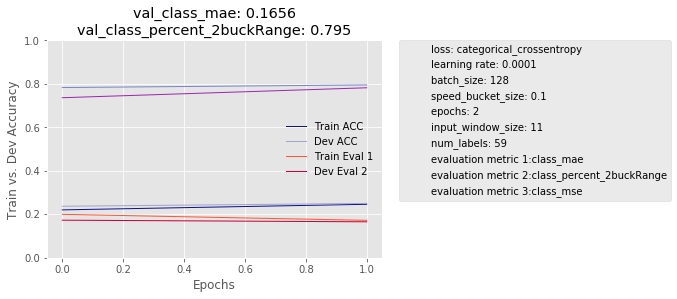

In [50]:
from matplotlib.patches import Rectangle
from matplotlib.legend import Legend

fig, ax1 = plt.subplots()
lines=[]

lines += ax1.plot(trainAccuracy_4,'#0e128c', label='Train Accuracy 2', linewidth=1) #'#DAF7A6'
lines += ax1.plot(devAccuracy_4,'#a3a4cc', label='Dev Accuracy 2', linewidth=1)# '#33FF00',
lines += ax1.plot(trainAccuracy_1,'#FF5733', label='Train Accuracy 1', linewidth=1)
lines += ax1.plot(devAccuracy_1,'#C70039', label='Dev Accuracy 1', linewidth=1)
lines += ax1.plot(trainAccuracy_2,'#9C27B0', label='Train Accuracy 2', linewidth=1)
lines += ax1.plot(devAccuracy_2,'#7986CB', label='Dev Accuracy 2', linewidth=1)
plt.ylim([0.0, 1.0])  # Surpress this for non-classification tasks

plt.ylabel('Train vs. Dev Accuracy')

plt.xlabel('Epochs')
plt.title(dev_reporting_metric_1 + ": " + str(np.around(final_accuracy_dev_1,4)) + "\n" + \
         dev_reporting_metric_2 + ": " + str(np.around(final_accuracy_dev_2,4))) 
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend([extra,extra,extra,extra,extra,extra,extra,extra,extra,extra],(
                                                "loss: " + loss_function,
                                                "learning rate: " + str(learning_rate),
                                                "batch_size: " + str(batch_size),
                                                "speed_bucket_size: " + speed_bucket_size,
                                                "epochs: "+str(training_epochs),
                                                "input_window_size: " + str(input_window_size),
                                                "num_labels: " + str(len(labels_to_number)),
                                                "evaluation metric 1:"+accuracy_reporting_metric_1,
                                                "evaluation metric 2:"+accuracy_reporting_metric_2,
                                                "evaluation metric 3:"+accuracy_reporting_metric_3,
                                                "note:" + plot_note),
                                                bbox_to_anchor=(1.05, 1),
                                                loc=2,
                                                borderaxespad=0.)

leg = Legend(ax1, lines[0:], ['Train ACC', 'Dev ACC','Train Eval 1','Dev Eval 2'],
             loc='bestoutside', frameon=False)
ax1.add_artist(leg);
plt.savefig("../Learning Curves/" + str(file_name) + "_AccuracyPerEpoch_Image.png", bbox_inches = "tight")
plt.show()

#### Record results of a model in a table:

In [17]:
model_time = end_time-start_time
time_per_epoch = model_time/training_epochs

# Add the results of the most recent run to the results file for documentation
a=[["FCN",
    file_name,
    "na",
    myFileLocation,
    training_epochs,  
    model_time,
    final_accuracy_1,
    final_accuracy_dev_1,
    final_accuracy_2,
    final_accuracy_dev_2,
    final_accuracy_3,
    final_accuracy_dev_3,
    batch_size,
    num_hidden_fc_layers,
    activations_strategy,
    dropout_rates,    
    learning_rate,
    speed_bucket_size,
    loss_function,
    input_window_size,
    label_window_size,
    accuracy_reporting_metric_1,
    accuracy_reporting_metric_2,
    accuracy_reporting_metric_3
    ]]
        
df=pd.DataFrame(a, columns=["model type",
                            "model filename",
                            "plot filename",
                            "data filename",
                            "epochs",
                            "runtime",
                            "train accuracy 1",
                            "dev accuracy 1",
                            "train accuracy 2",
                            "dev accuracy 2",
                            "train accuracy 3",
                            "dev accuracy 3",
                            "batch_size",
                            "num_hidden_fc_layers",
                            "activations_strategy",
                            "dropout_rates",    
                            "learning_rate",
                            "speed_bucket_size",
                            "loss_function",
                            "input_window_size",
                            "label_window_size",
                            "evaluation_metric_1",
                            "evaluation_metric_2",
                            "evaluation_metric_3"])

past_results = load_results_file(results_file_name)
past_results=pd.concat([past_results,df])
print(past_results)
past_results.to_csv("../Model Performance Tables/" + results_file_name + ".csv",index=False ) # FIX TO PUT THE COLUMNS NOT ALPHABETICAL

Found results file
['activations_strategy', 'batch_size', 'data filename', 'dev accuracy 1', 'dev accuracy 2', 'dev accuracy 3', 'dropout_rates', 'epochs', 'evaluation_metric_1', 'evaluation_metric_2', 'evaluation_metric_3', 'input_window_size', 'label_window_size', 'learning_rate', 'loss_function', 'model filename', 'model type', 'num_hidden_fc_layers', 'plot filename', 'runtime', 'speed_bucket_size', 'train accuracy 1', 'train accuracy 2', 'train accuracy 3', 'train accuracy 4']
             activations_strategy  batch_size  \
0                     r-r-r-r-r-r         128   
1                     r-r-r-r-r-r         128   
2                     r-r-r-r-r-r         128   
3                     r-r-r-r-r-r         128   
4  relu_relu_relu_relu_relu_relu_         128   
0  relu_relu_relu_relu_relu_relu_         128   

                                       data filename  dev accuracy 1  \
0  C:/Users/adam/Documents/CS 230/Project/Lumo Da...        0.000000   
1  C:/Users/adam/Documents

PermissionError: [Errno 13] Permission denied: '../Model Performance Tables/Default_Model_Results_Storage_Table_20180712.csv'

#### Build Confusion Matrix and Regression Plot

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

y_true = y_test
y_true_argmax = np.argmax(y_true, axis=1)

In [ ]:
# Plot results
plt.scatter(y_true_argmax, y_pred_argmax, s=3, alpha=0.3)
plt.scatter(y_true_argmax, y_true_argmax, s=3, alpha=1)
#plt.scatter(y_true, y_pred, s=3, alpha=0.3) # For regression
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Y_True')
plt.ylabel('Y_Prediction')
plt.savefig("../Confusion Matrices/" + str(file_name) + "_ConfusionMatrix_Image.png")
plt.show()

# Record data in a .csv
y_trueVy_pred = np.vstack([y_true_argmax,y_pred_argmax])
df_y_trueVy_pred = pd.DataFrame(np.transpose(y_trueVy_pred))
filepath_predictions = "../Model Final Predictions/" + str(file_name) + "_Predictions" + ".csv"
df_y_trueVy_pred.to_csv(filepath_predictions, header = ["y_true_argmax", "y_pred_argmax"], index=False)

# Create and save a confusion matrix
cm = confusion_matrix(y_true_argmax, y_pred_argmax)
df_cm = pd.DataFrame (cm)
filepath_cm = "../Confusion Matrices/" + str(file_name) + "_ConfusionMatrix_Data.xlsx"
df_cm.to_excel(filepath_cm, index=False)

### End of Script